In [ ]:
import os
import sys
import pickle as pkl
import pandas as pd
import src.data.Preprocessing as pproc
import seaborn as sns

repo_path = 'C:\\Users\\Familia\\Desktop\\GitHub\\ada-2023-project-adacadabra2023' # CHANGE
sys.path.append(repo_path)

# from src.data.Data import load_data

This section corresponds to what is shown in the country recommender in the website and also to what is implemented in main_dfs_web/classifier.py

In [ ]:
dpath = os.path.join(repo_path, 'Data', 'Unified_ratings.pkl')
with open(dpath, 'rb') as f:
    df = pkl.load(f)
print(df.shape)

(12935301, 19)


In [ ]:
dpath = os.path.join(repo_path, 'Data', 'Unified_users.pkl')
with open(dpath, 'rb') as f:
    df_users = pkl.load(f)
print(df_users.shape)

(45568, 6)


In [ ]:
df_users

,nbr_ratings_rb,user_id,user_name,location,nbr_ratings_ba,total_nbr_ratings
0,1890.0,175852.0,Manslow,Poland,0.0,1890.0
1,89.0,442761.0,MAGICuenca91,Spain,0.0,89.0
2,169.0,288889.0,Sibarh,Poland,0.0,169.0
3,3371.0,250510.0,fombe89,Spain,0.0,3371.0
4,13043.0,122778.0,kevnic2008,Germany,0.0,13043.0
...,...,...,...,...,...,...
45563,0.0,36790.0,alfrantzell,"United States, California",43.0,43.0
45564,0.0,36791.0,chefpeet,"United States, New Jersey",22.0,22.0
45565,0.0,36792.0,Dwarf,NaN,21.0,21.0
45566,0.0,36793.0,Tnudish,NaN,34.0,34.0


In [ ]:
# This is included in the main_preprocessing, but was developed in this part
def filter_countries(df, min_styles=3):
    ''' Filters countries that do not have at least min_styles styles per trimester.
    Args:
        df: Unified_ratings dataframe coming from main_preprocessing
        min_styles (int) min umber of styles
    '''
    filtered_df = df[['style','Trimester','country_brewery']]

    sty_country = filtered_df.groupby(['country_brewery', 'Trimester'], as_index=False).nunique()

    select_countries = sty_country.groupby('country_brewery', as_index=False).min()
    keep_countries = select_countries[select_countries['style'] >= min_styles]
    valid_countries = keep_countries.country_brewery.values
    filtered_countries = filtered_df[filtered_df['country_brewery'].isin(valid_countries)]
    return filtered_countries

## Dataframe creation for the classifier:

In [ ]:
palette_styles = dict(zip(df['macro_style'].unique(), sns.color_palette('tab20', 20)[:20]))

In [ ]:
def weighted_average(group):
    # Define weights based on 'expertise'
    weights = {1: 1.5, 0: 1}

    # Calculate the weighted average
    weighted_avg = (group['detrend'] * group['expertise'].map(weights)).sum() / group['expertise'].map(weights).sum()

    return pd.Series({'macro_style': group['macro_style'].iloc[0], 'country_brewery': group['country_brewery'].iloc[0], 'final_score': weighted_avg})

weighted_scores = df.groupby(['country_brewery', 'Trimester', 'macro_style'], as_index=False).apply(weighted_average)
weighted_scores = weighted_scores.sort_values(by=['country_brewery', 'Trimester', 'final_score'],  ascending=[True, True, False])
desired_order = ['country_brewery', 'Trimester', 'macro_style', 'final_score']
weighted_scores = weighted_scores[desired_order]
weighted_scores

,country_brewery,Trimester,macro_style,final_score
0,Albania,T1,Dark Lager,-0.978845
1,Albania,T1,Pilsner & Pale Lager,-2.195745
2,Albania,T2,Dark Lager,-1.285498
3,Albania,T2,Pilsner & Pale Lager,-2.121322
4,Albania,T3,Dark Lager,-1.266197
...,...,...,...,...
4805,Wales,T4,Wheat Beer,-0.294702
4794,Wales,T4,Herbs/Vegetables,-0.300357
4797,Wales,T4,Pale Ale,-0.307982
4793,Wales,T4,Dark Lager,-0.360175


In [ ]:
top_3_beerstyles = weighted_scores.groupby(['country_brewery', 'Trimester']).head(3)

styles_combined = top_3_beerstyles.groupby(['country_brewery', 'Trimester'], as_index= False).agg(lambda x: x.tolist())

styles_combined[['1st_Style', '2nd_Style', '3rd_Style']] = pd.DataFrame(styles_combined['macro_style'].tolist(), index=styles_combined.index)
styles_combined[['1st_Score', '2nd_Score', '3rd_Score']] = pd.DataFrame(styles_combined['final_score'].tolist(), index=styles_combined.index)
styles_combined = styles_combined.drop(['macro_style', 'final_score'], axis=1)
styles_combined

,country_brewery,Trimester,1st_Style,2nd_Style,3rd_Style,1st_Score,2nd_Score,3rd_Score
0,Albania,T1,Dark Lager,Pilsner & Pale Lager,None,-0.978845,-2.195745,NaN
1,Albania,T2,Dark Lager,Pilsner & Pale Lager,None,-1.285498,-2.121322,NaN
2,Albania,T3,Dark Lager,Pilsner & Pale Lager,None,-1.266197,-2.152081,NaN
3,Albania,T4,Dark Lager,Pilsner & Pale Lager,None,-1.514507,-2.414001,NaN
4,Andorra,T1,Pilsner & Pale Lager,Amber Ale,Pale Ale,-1.327943,-1.512699,-1.525044
...,...,...,...,...,...,...,...,...
523,Virgin Islands (U.S.),T4,IPA,Amber Ale,Wheat Beer,-0.481893,-0.909342,-0.945725
524,Wales,T1,Amber Ale,IPA,Wild/Sour Beer,0.394771,0.161345,0.100542
525,Wales,T2,Amber Ale,IPA,Strong Brown/Dark Ale,0.306489,0.186952,0.141831
526,Wales,T3,IPA,Amber Ale,Strong Brown/Dark Ale,0.219864,0.154380,0.010825


In [ ]:
with open('Data/web/Train.pkl', 'wb') as f:
    pkl.dump(styles_combined, f)

## Training of the seasonal classifiers

In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import pandas as pd

We can now load the dataset used for the training. Scores are those resulting from the herding correction:

In [5]:
#Load the data:
training_df = pd.read_pickle('../Data/web/Train.pkl') 
training_df.head()

,country_brewery,Trimester,1st_Style,2nd_Style,3rd_Style,1st_Score,2nd_Score,3rd_Score
0,Argentina,T1,Smoked,IPA,Stout,-0.001069,-0.240452,-0.368807
1,Argentina,T2,Wild/Sour Beer,IPA,Porter,0.627596,0.015085,-0.387585
2,Argentina,T3,Smoked,Bock,Stout,-0.014951,-0.189497,-0.321432
3,Argentina,T4,Bock,Stout,Strong Pale Ale,0.179469,-0.173703,-0.307675
4,Australia,T1,Strong Brown/Dark Ale,Wild/Sour Beer,IPA,0.437873,0.154562,0.151838


As explained in the README, we only have one row per country and season and thus we do not split in train and validation

In [8]:
def train_single_tree(season_df):
    # Features (X)
    features = season_df[['1st_Style', '2nd_Style', '3rd_Style']]

    # Target variable (y)
    target = season_df['country_brewery']


    # Define the columns and transformers for encoding
    categorical_features = ['1st_Style', '2nd_Style', '3rd_Style']

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ])

    # Create the Decision Tree Classifier
    dtc = DecisionTreeClassifier(random_state=27)


    # Create the pipeline
    dtc_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', dtc)])


    # Train the model on the training data
    dtc_model.fit(features, target)

    # Make predictions on the test set
    y_pred = dtc_model.predict(features)

    # Evaluate the accuracy
    accuracy = accuracy_score(target, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    return dtc_model

In [9]:
all_trees = []
for t in training_df.Trimester.unique():
    print('Training for trimester', t)
    season_df = training_df[training_df.Trimester==t]
    tree = train_single_tree(season_df)
    all_trees.append(tree)

Training for trimester T1
Accuracy: 0.9474
Training for trimester T2
Accuracy: 0.9123
Training for trimester T3
Accuracy: 0.8772
Training for trimester T4
Accuracy: 0.9123


We can now visualize one of the trees as an example (the one for the first trimester). Since the variables are one-hot encoded and all decisions are binary, it's hard to clearly visualize the individual decisions, but we can see the whole structure. Nonetheless, meaningful conclusions are hard to extract from this tree, we would ideally have a decision tree with 3 levels where each split is based on choosing between the 20 beer styles.

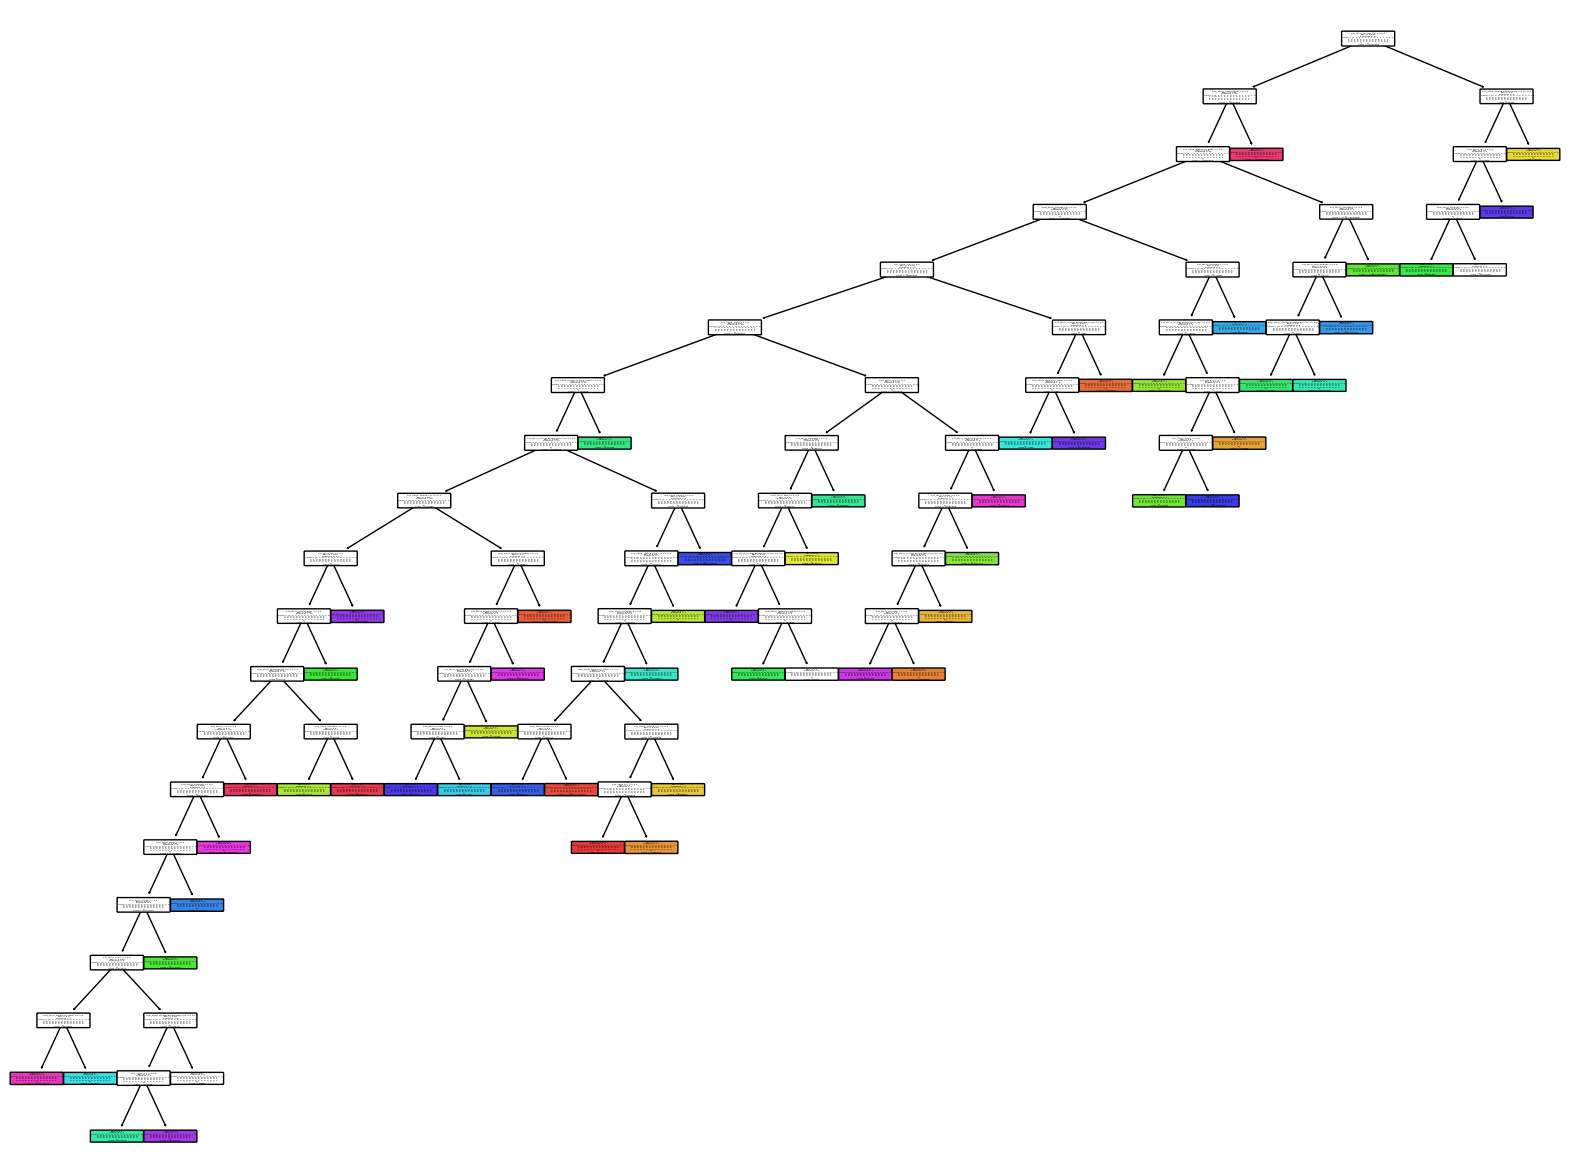

In [11]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Get the class names
target = season_df['country_brewery']
categorical_features = ['1st_Style', '2nd_Style', '3rd_Style']
class_names = list(target.unique())
dtc_model = all_trees[0]
# Visualize the Decision Tree
plt.figure(figsize=(20, 15))
plot_tree(dtc_model['classifier'], feature_names=dtc_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features), class_names=class_names, filled=True, rounded=True)
plt.show()